## 1. Introducción

Este notebook entrena y compara varios modelos de Machine Learning para un prototipo de detección de phishing en el contexto español.

- **Dataset**: 200 URLs balanceadas (100 legítimas / 100 phishing), con 10 features seleccionadas tras el EDA.  
- **Objetivo**: evaluar distintos algoritmos y seleccionar un modelo base interpretable para el prototipo, usando validación cruzada por el tamaño reducido del dataset.  
- **Modelos considerados**:  
  - Regresión Logística (`LogisticRegression`)  
  - Máquinas de Vectores de Soporte (`SVC`)  
  - Bosques Aleatorios (`RandomForestClassifier`)  
  - XGBoost (`XGBClassifier`)  
- **Métricas de evaluación**: Accuracy, Precision, Recall, F1-score, ROC-AUC y matriz de confusión.  
  - (Opcionalmente se incluye **Specificity / TNR**, equivalente a la tasa de verdaderos negativos).


In [39]:
# --- Imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from datetime import datetime
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Configuración global
RANDOM_STATE = 42



In [40]:
# Cargar dataset completo (se reutiliza después para campañas/sectores)
DATASET_PATH = Path("../data/dataset/dataset_prototipo.csv")
df_full = pd.read_csv(DATASET_PATH)

# Checks mínimos (silenciosos si todo OK)
expected_cols = {"url", "label", "categoria", "matched_target", "notas", "campaign"}
missing = expected_cols - set(df_full.columns)
assert not missing, f"Faltan columnas: {missing}"

vc = df_full["label"].value_counts().to_dict()
assert vc == {0: 100, 1: 100}, f"Balance esperado 100/100, obtenido: {vc}"
assert len(df_full) == 200, f"Filas esperadas 200, obtenidas: {len(df_full)}"

print("✅ dataset_prototipo.csv OK: 200 filas, balance 100/100 y columnas esperadas.")


✅ dataset_prototipo.csv OK: 200 filas, balance 100/100 y columnas esperadas.


In [41]:
# Seleccionar X (features) e y (target)
X = df_features[feature_cols].copy()
y = df_features["label"].astype(int)

# Checks básicos
assert X.shape == (200, 10), f"Esperado (200,10), obtenido {X.shape}"
assert y.shape == (200,), f"Esperado (200,), obtenido {y.shape}"
assert y.value_counts().to_dict() == {0: 100, 1: 100}, f"Distribución incorrecta: {y.value_counts().to_dict()}"

print("✅ features_prototipo.csv OK: 200 filas, 10 features, balance 100/100")


✅ features_prototipo.csv OK: 200 filas, 10 features, balance 100/100


In [42]:
# =============================
# 📌 Preprocesamiento y Modelos baseline
# =============================

# Identificar columnas numéricas y categóricas
numeric_cols = [
    "domain_length", "domain_entropy", "num_params",
    "trusted_path_token", "contains_percent", "contains_equal",
    "suspicious_path_token", "free_hosting"
]
categorical_cols = ["protocol", "tld_group"]

# Check: asegurar que se cubren todas las features
assert set(feature_cols) == set(numeric_cols + categorical_cols)

# Preprocesamiento: escalar numéricas + one-hot en categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

# Modelos baseline
models = {
    "LogReg": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "RandForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, kernel="linear", random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric="logloss"
    )
}

# Métricas de evaluación
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]


In [43]:
# =============================
# 📌 Validación cruzada (k=5..10)
# =============================

results_kfolds = []

for k in range(5, 11):
    cv_k = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    for name, clf in models.items():
        pipe = Pipeline(steps=[("pre", preprocessor), ("clf", clf)])
        scores = cross_validate(pipe, X, y, cv=cv_k, scoring=scoring)
        
        row = {"model": name, "k": k}
        for m in scoring:
            row[f"{m}_mean"] = scores[f"test_{m}"].mean()
            row[f"{m}_std"]  = scores[f"test_{m}"].std()
        results_kfolds.append(row)

res_k_df = pd.DataFrame(results_kfolds)

# Tabla agregada por modelo (promedio de todos los k)
summary_df = (
    res_k_df.groupby("model")[ [f"{m}_mean" for m in scoring] ]
    .mean()
    .round(3)
    .reset_index()
)
display(summary_df)


,model,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean
0,LogReg,0.907,0.922,0.898,0.906,0.946
1,RandForest,0.875,0.879,0.877,0.875,0.940
2,SVC,0.885,0.889,0.893,0.886,0.947
3,XGBoost,0.828,0.841,0.827,0.824,0.930


,threshold,precision_mean,precision_std,recall_mean,recall_std
0,0.500,0.922,0.065,0.899,0.069
1,0.475,0.897,0.076,0.908,0.062
2,0.450,0.881,0.078,0.909,0.060
3,0.425,0.873,0.072,0.918,0.063
4,0.400,0.854,0.082,0.922,0.064
5,0.375,0.847,0.082,0.922,0.064
6,0.350,0.845,0.083,0.922,0.064
7,0.325,0.836,0.090,0.922,0.064
8,0.300,0.816,0.097,0.927,0.065
9,0.275,0.796,0.106,0.935,0.067


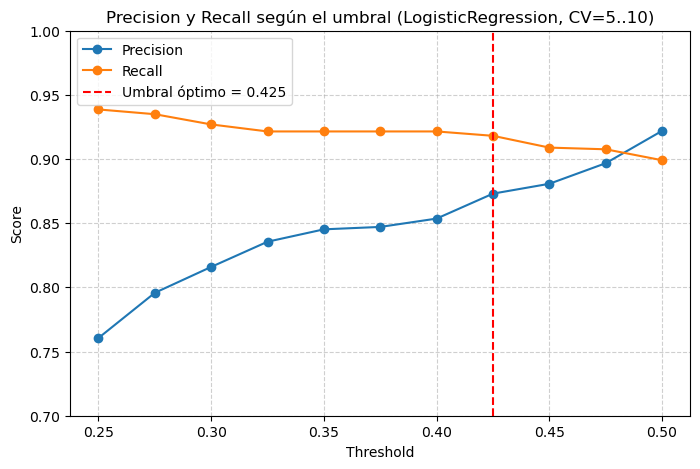

In [67]:
# =============================
# 📌 Evaluación de thresholds (LogisticRegression, CV=5..10)
# =============================

base_model = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

# Umbrales a evaluar
thresholds = np.arange(0.50, 0.24, -0.025)  # 0.50, 0.475, ..., 0.25

results_thresholds = []

for thr in thresholds:
    precisions, recalls = [], []
    
    # Validación cruzada con k=5..10
    for k in range(5, 11):
        cv_k = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
        for train_idx, test_idx in cv_k.split(X, y):
            base_model.fit(X.iloc[train_idx], y.iloc[train_idx])
            y_scores = base_model.predict_proba(X.iloc[test_idx])[:, 1]
            y_pred_thr = (y_scores >= thr).astype(int)

            precisions.append(precision_score(y.iloc[test_idx], y_pred_thr))
            recalls.append(recall_score(y.iloc[test_idx], y_pred_thr))
    
    results_thresholds.append({
        "threshold": thr,
        "precision_mean": np.mean(precisions),
        "precision_std": np.std(precisions),
        "recall_mean": np.mean(recalls),
        "recall_std": np.std(recalls)
    })

# DataFrame final con medias y std por threshold
thr_df = pd.DataFrame(results_thresholds).sort_values("threshold", ascending=False)
display(thr_df.round(3))

# =============================
# 📌 Gráfica Precision vs Recall según threshold (media CV=5..10)
# =============================

plt.figure(figsize=(8,5))
plt.plot(thr_df["threshold"], thr_df["precision_mean"], marker="o", label="Precision")
plt.plot(thr_df["threshold"], thr_df["recall_mean"], marker="o", label="Recall")

# Marcar el umbral elegido
opt_thr = 0.425
plt.axvline(x=opt_thr, color="red", linestyle="--", label=f"Umbral óptimo = {opt_thr}")

# Ajustes
plt.title("Precision y Recall según el umbral (LogisticRegression, CV=5..10)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.savefig("../entrenamiento/img/precision_recall_threshold.png",
            dpi=150, bbox_inches="tight")

plt.show()



Resultados globales promedio (umbral=0.425, CV=5..10):
TN=11, FP=2, FN=1, TP=12
→ Recall phishing: 0.923
→ Precision phishing: 0.857


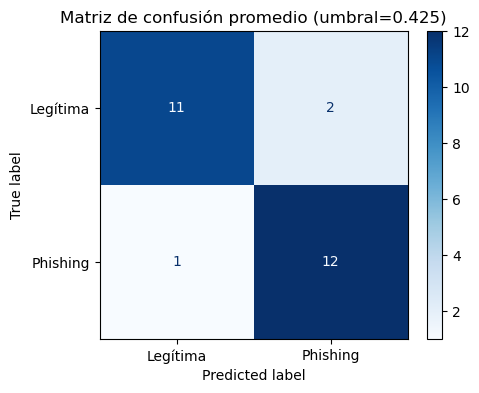

In [57]:
# =============================
# 📌 Matriz de confusión promedio (CV=5..10) + gráfica
# =============================

conf_matrices = []

for k in range(5, 11):
    cv_k = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    for train_idx, test_idx in cv_k.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        pipe.fit(X_train, y_train)
        probs = pipe.predict_proba(X_test)[:, 1]
        y_pred = (probs >= opt_thr).astype(int)
        
        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        conf_matrices.append(cm)

# Promedio de las matrices
cm_mean = np.mean(conf_matrices, axis=0).round().astype(int)

tn, fp, fn, tp = cm_mean.ravel()
print(f"Resultados globales promedio (umbral={opt_thr}, CV=5..10):")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"→ Recall phishing: {tp / (tp+fn):.3f}")
print(f"→ Precision phishing: {tp / (tp+fp):.3f}")

# -----------------------------
# Gráfica
# -----------------------------
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=["Legítima", "Phishing"])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title(f"Matriz de confusión promedio (umbral={opt_thr})")

# Guardar en carpeta
plt.savefig("../entrenamiento/img/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()


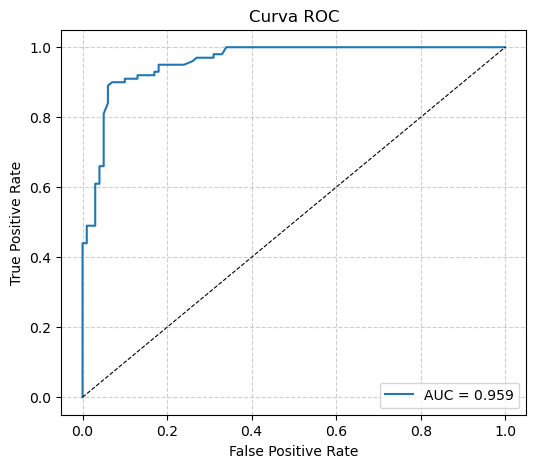

In [58]:
# =============================
# 📌 Curva ROC (LogisticRegression, umbral libre)
# =============================

# Probabilidades en todo el dataset
y_proba = pipe.predict_proba(X)[:, 1]

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--", linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Guardar
plt.savefig("../entrenamiento/img/roc_auc.png", dpi=150, bbox_inches="tight")
plt.show()


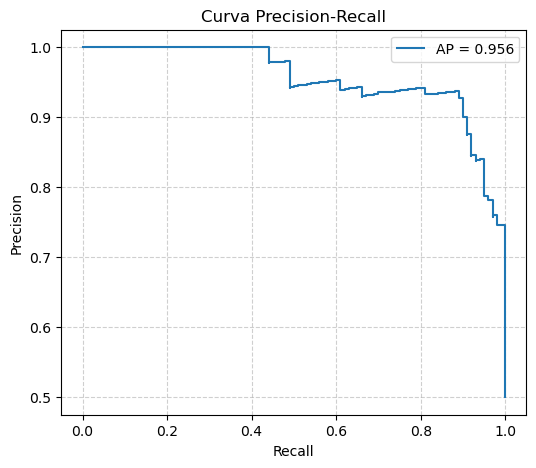

In [60]:
# =============================
# 📌 Curva Precision-Recall
# =============================
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y, y_proba)
ap = average_precision_score(y, y_proba)

plt.figure(figsize=(6,5))
plt.step(rec, prec, where="post", label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Guardar
plt.savefig("../entrenamiento/img/precision_recall_curve.png", dpi=150, bbox_inches="tight")
plt.show()


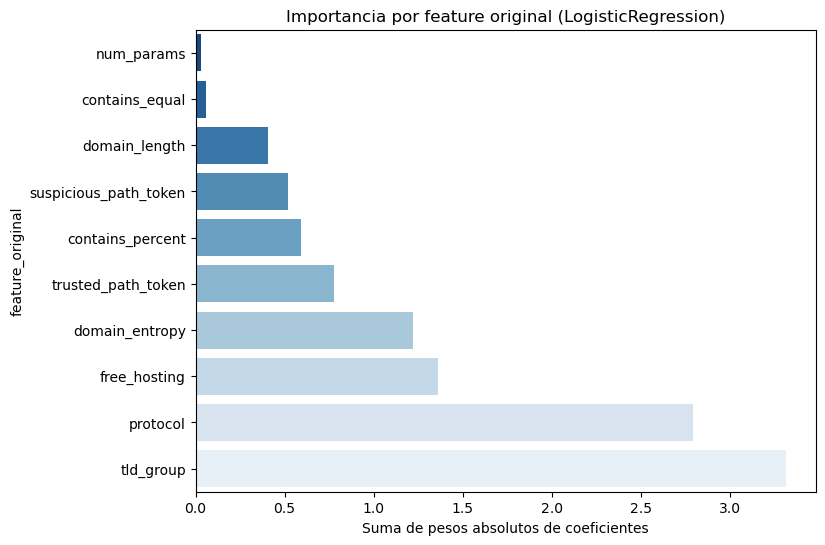

In [64]:
# Mapeo manual de features expandidas a originales
def map_to_original(name):
    if "domain_length" in name:
        return "domain_length"
    elif "domain_entropy" in name:
        return "domain_entropy"
    elif "num_params" in name:
        return "num_params"
    elif "contains_percent" in name:
        return "contains_percent"
    elif "contains_equal" in name:
        return "contains_equal"
    elif "contains_at" in name:
        return "contains_at"
    elif "suspicious_path_token" in name:
        return "suspicious_path_token"
    elif "trusted_path_token" in name:
        return "trusted_path_token"
    elif "free_hosting" in name:
        return "free_hosting"
    elif "protocol" in name:
        return "protocol"
    elif "tld_group" in name:
        return "tld_group"
    else:
        return name  # fallback

imp_df["feature_original"] = imp_df["feature_expanded"].apply(map_to_original)

# Agrupar de nuevo
imp_grouped = (
    imp_df.groupby("feature_original")["importance"]
    .sum()
    .reset_index()
    .sort_values("importance", ascending=True)
)

# Gráfica
plt.figure(figsize=(8,6))
sns.barplot(data=imp_grouped, x="importance", y="feature_original", palette="Blues_r")
plt.title("Importancia por feature original (LogisticRegression)")
plt.xlabel("Suma de pesos absolutos de coeficientes")

plt.savefig("../entrenamiento/img/feature_importance_grouped_clean.png",
            dpi=150, bbox_inches="tight")
plt.show()


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_86667/3588716181.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["pred"] == 1).sum() / len(g))


,target,recall
18,microsoft,0.000
28,walletconnect,0.000
22,outlook,0.000
5,caixabank,0.500
8,correos,0.667
7,coinbase,0.917
15,ing,0.917
13,genérico,0.941
25,santander,1.000
23,roblox,1.000


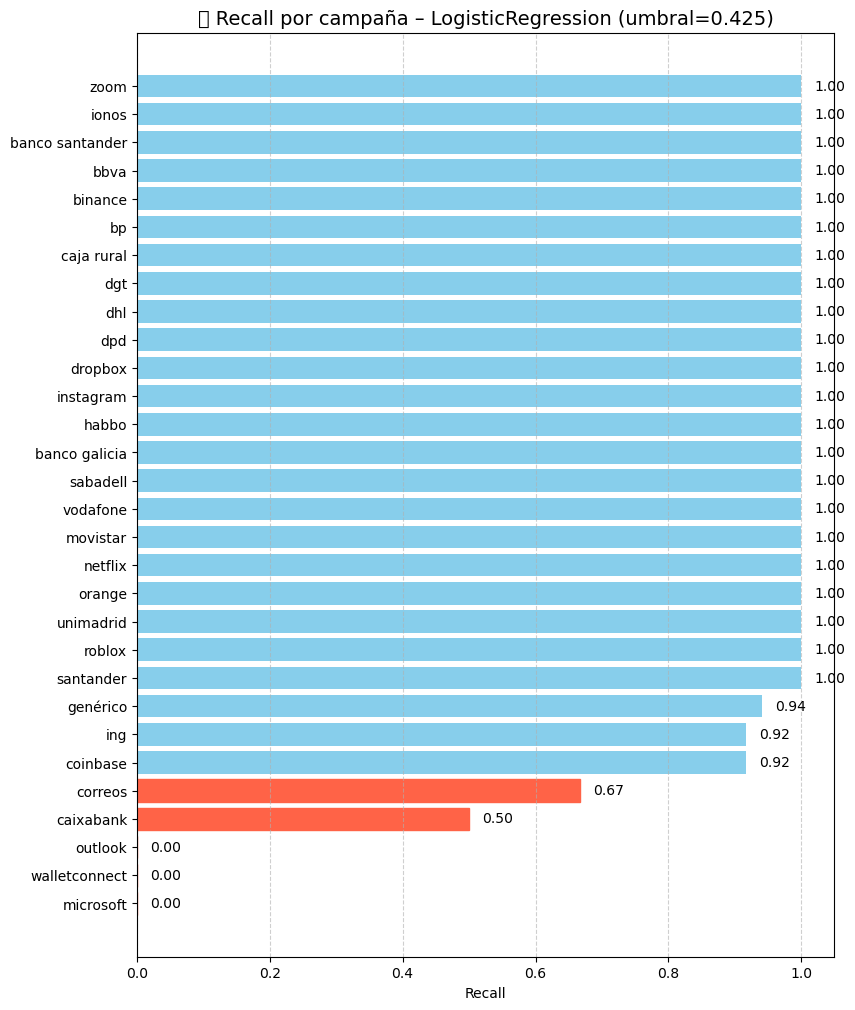

In [66]:
# =============================
# 📌 Recall por campaña (matched_target, CV=5..10)
# =============================

y_true_all, y_pred_all, targets_all = [], [], []

for k in range(5, 11):
    cv_k = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    for train_idx, test_idx in cv_k.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        targets = df_full.iloc[test_idx]["matched_target"]
        
        pipe.fit(X_train, y_train)
        probs = pipe.predict_proba(X_test)[:, 1]
        y_pred = (probs >= opt_thr).astype(int)
        
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        targets_all.extend(targets)

pred_df = pd.DataFrame({"true": y_true_all, "pred": y_pred_all, "target": targets_all})

# Solo phishing
phish_df = pred_df[pred_df["true"] == 1]

# Recall medio por target
recall_by_target = (
    phish_df.groupby("target")
    .apply(lambda g: (g["pred"] == 1).sum() / len(g))
    .reset_index(name="recall")
    .sort_values("recall", ascending=True)
)

# Mostrar tabla
display(recall_by_target.round(3))

# -----------------------------
# Gráfica
# -----------------------------
plt.figure(figsize=(9,12))
bars = plt.barh(recall_by_target["target"], recall_by_target["recall"], color="skyblue")

# Colorear campañas con recall <0.9 en rojo
for i, val in enumerate(recall_by_target["recall"]):
    if val < 0.9:
        bars[i].set_color("tomato")

plt.title("📊 Recall por campaña – LogisticRegression (umbral=0.425)", fontsize=14)
plt.xlabel("Recall")
plt.xlim(0, 1.05)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Mostrar valores
for i, val in enumerate(recall_by_target["recall"]):
    plt.text(val + 0.02, i, f"{val:.2f}", va="center")

# 👉 Guardar
plt.savefig("../entrenamiento/img/recall_por_campana.png",
            dpi=150, bbox_inches="tight")

plt.show()


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_86667/1548017846.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["pred"]==1).sum() / len(g))


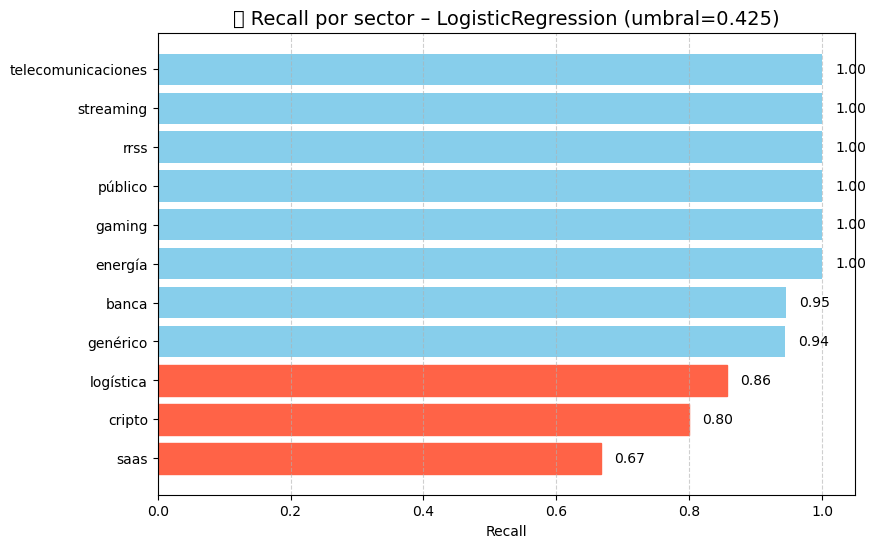

In [65]:
# =============================
# 📌 Recall por sector (categoria)
# =============================

# Arrays acumulados
y_true_all, y_pred_all, categorias_all = [], [], []

cv_k = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

for train_idx, test_idx in cv_k.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    categorias = df_full.iloc[test_idx]["categoria"]
    
    pipe.fit(X_train, y_train)
    probs = pipe.predict_proba(X_test)[:, 1]
    y_pred = (probs >= opt_thr).astype(int)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    categorias_all.extend(categorias)

pred_df_sector = pd.DataFrame({
    "true": y_true_all,
    "pred": y_pred_all,
    "categoria": categorias_all
})

# Filtrar phishing
phish_df_sector = pred_df_sector[pred_df_sector["true"] == 1]

# Recall por sector
recall_by_sector = (
    phish_df_sector.groupby("categoria")
    .apply(lambda g: (g["pred"]==1).sum() / len(g))
    .reset_index(name="recall")
    .sort_values("recall", ascending=True)
)

# Gráfica
plt.figure(figsize=(9,6))
bars = plt.barh(recall_by_sector["categoria"], recall_by_sector["recall"], color="skyblue")

# Colorear sectores con recall <0.9
for i, val in enumerate(recall_by_sector["recall"]):
    if val < 0.9:
        bars[i].set_color("tomato")

plt.title("📊 Recall por sector – LogisticRegression (umbral=0.425)", fontsize=14)
plt.xlabel("Recall")
plt.xlim(0, 1.05)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Mostrar valores
for i, val in enumerate(recall_by_sector["recall"]):
    plt.text(val + 0.02, i, f"{val:.2f}", va="center")

# 👉 Guardar en carpeta de imágenes del entrenamiento
plt.savefig("../entrenamiento/img/recall_por_sector.png",
            dpi=150, bbox_inches="tight")

plt.show()


In [49]:
# =============================
# 📌 Entrenamiento final con todo el dataset
# =============================

final_model = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])
final_model.fit(X, y)

# Diccionario con modelo + info útil
artifact = {
    "model": final_model,
    "threshold": 0.425,
    "features": feature_cols,
    "metadata": {
        "trained_on": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "n_samples": len(X),
        "n_features": len(feature_cols),
        "classes": {0: "legítima", 1: "phishing"}
    }
}

# Guardar en disco
Path("../models").mkdir(parents=True, exist_ok=True)
output_path = "../models/logreg_phishing_final.joblib"
joblib.dump(artifact, output_path)

print(f"✅ Modelo final entrenado y guardado en {output_path}")

✅ Modelo final entrenado y guardado en ../models/logreg_phishing_final.joblib


In [50]:
# =============================
# 📌 Ejemplo: Cargar modelo y usarlo para predecir
# =============================

# Cargar artifact guardado
artifact_loaded = joblib.load("../models/logreg_phishing_final.joblib")

model_loaded = artifact_loaded["model"]
threshold = artifact_loaded["threshold"]
features = artifact_loaded["features"]

print("✅ Modelo cargado correctamente")
print("Metadata:", artifact_loaded["metadata"])

# --- Ejemplo: tomar una fila del dataset de features
sample = X.iloc[[0]]   # la primera URL del dataset
proba = model_loaded.predict_proba(sample)[:, 1][0]
pred = int(proba >= threshold)

print(f"\nURL: {df_full.iloc[0]['url']}")
print(f"Probabilidad phishing: {proba:.3f}")
print(f"Predicción final: {'Phishing' if pred==1 else 'Legítima'}")


✅ Modelo cargado correctamente
Metadata: {'trained_on': '2025-09-16 13:41:29', 'n_samples': 200, 'n_features': 10, 'classes': {0: 'legítima', 1: 'phishing'}}

URL: https://www.caixabank.es/particular/banca-digital.html
Probabilidad phishing: 0.100
Predicción final: Legítima


In [51]:
# =============================
# 📌 Ejemplo: predicción en lote con el modelo cargado
# =============================

# Tomamos las 5 primeras URLs del dataset
samples = X.iloc[:5]
urls = df_full.iloc[:5]["url"].tolist()

# Probabilidades de phishing
probas = model_loaded.predict_proba(samples)[:, 1]

# Aplicar umbral
preds = (probas >= threshold).astype(int)

# Construir DataFrame de resultados
results_df = pd.DataFrame({
    "url": urls,
    "prob_phishing": probas.round(3),
    "pred": ["Phishing" if p==1 else "Legítima" for p in preds]
})

display(results_df)


,url,prob_phishing,pred
0,https://www.caixabank.es/particular/banca-digi...,0.100,Legítima
1,https://accounts.google.com/ServiceLogin?servi...,0.035,Legítima
2,https://www.roblox.com/es/upgrades/robux?ctx=n...,0.298,Legítima
3,https://zoom.us/es/join,0.280,Legítima
4,https://www.roblox.com/es/login,0.026,Legítima
